#### Imports and env creation

In [1]:
# from __future__ import annotations

from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.core.constants import IDX_TO_OBJECT, OBJECT_TO_IDX
import gymnasium as gym

from minigrid.core.actions import Actions
from dataclasses import dataclass, field 
from typing import Set
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

pygame 2.5.2 (SDL 2.28.2, Python 3.10.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
WORLD_N=40 #Num of pixels in the side
WORLD_N_SQ = WORLD_N**2

# class SimpleEnv(MiniGridEnv):
#     def __init__(
#         self,
#         size=WORLD_N,
#         agent_start_pos=(1, 1),
#         agent_start_dir=0,
#         max_steps: int | None = None,
#         **kwargs,
#     ):
#         self.agent_start_pos = agent_start_pos
#         self.agent_start_dir = agent_start_dir

#         mission_space = MissionSpace(mission_func=self._gen_mission)

#         super().__init__(
#             mission_space=mission_space,
#             grid_size=size,
#             max_steps=256,
#             **kwargs,
#         )

#     @staticmethod
#     def _gen_mission():
#         return "grand mission"
    
    
#     def _gen_grid(self, width, height):
#       self.grid = Grid(width, height)
#       self.grid.wall_rect(0, 0, width, height)

#       if self.agent_start_pos is not None:
#           self.agent_pos = self.agent_start_pos
#           self.agent_dir = self.agent_start_dir
#       else:
#           self.place_agent()
#       self.valid_actions = {Actions.left, Actions.right, Actions.forward}
    
      
#       self.put_obj(Goal(), width - 2, height - 2)
      
#       self.grid.set(3, 1, Wall())
#       self.grid.set(3, 2, Wall())
#       self.grid.set(3, 4, Wall())
#       self.grid.set(3, 5, Wall())
    
#     def get_array_repr(self, with_agent=True):
#         grid_array = self.unwrapped.grid.encode()[:,:,0]
    
#         grid_array[self.agent_pos[0],self.agent_pos[1]]=OBJECT_TO_IDX['agent']
#         return grid_array.T
    
# env = gym.make("MiniGrid-Dynamic-Obstacles-5x5-v0", render_mode="rgb_array", tile_size=8)
env = gym.make("MiniGrid-Empty-5x5-v0", render_mode="rgb_array", tile_size=8)
env = env.unwrapped
env.valid_actions = {Actions.left, Actions.right, Actions.forward}

# env = SimpleEnv(render_mode="human")
# manual_control = ManualControl(env, seed=42)

def get_array_repr(env):
    grid_array = env.unwrapped.grid.encode()[:,:,0]
    # print(grid_array)
    # print(self.agent_pos)
    grid_array[env.agent_pos[0],env.agent_pos[1]]=OBJECT_TO_IDX['agent']
    return grid_array.T

# env = SimpleEnv()
env.reset()
print(get_array_repr(env))

# enable manual control for testing
# manual_control.start()

map_numbers = [1,2,3,4,5,6,7,8,9,10]


[[ 2  2  2  2  2]
 [ 2 10  1  1  2]
 [ 2  1  1  1  2]
 [ 2  1  1  8  2]
 [ 2  2  2  2  2]]


40
40
3


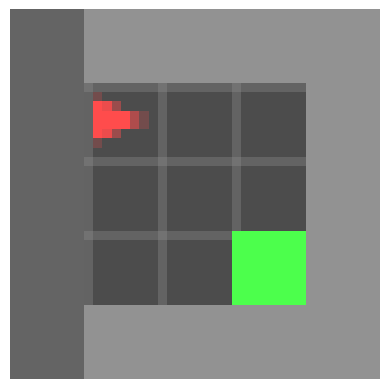

In [3]:

plt.axis('off')
plt.imshow(env.render())
print(len(env.render()))
print(len(env.render()[0]))
print(len(env.render()[0][0]))
# print(env.render())

#### Agent motion

In [4]:
from agents.random import RandomAgent
n_steps_train = 12000
n_steps_test = 3000

random_action_agent = RandomAgent(valid_actions=env.valid_actions)

dirarr = ['Right', 'Down', 'Left','Up']
actions_to_idx = {Actions.left:0, Actions.right:1, Actions.forward:2}

image_list_train = []

for i in range(n_steps_train):
    action = random_action_agent.act()
    arr = env.render()
    arr = np.append(arr, [actions_to_idx[action]])
    image_list_train.append(arr)
    # print(dirarr[env.agent_dir])
    # print(action)
    env.step(action)
    # print(env.get_array_repr())

env.reset()
image_list_test = []

for i in range(n_steps_test):
    action = random_action_agent.act()
    arr = env.render()
    arr = np.append(arr, [actions_to_idx[action]])
    image_list_test.append(arr)
    # print(dirarr[env.agent_dir])
    # print(action)
    env.step(action)

print(image_list_train[:3])

[array([100, 100, 100, ..., 146, 146,   0]), array([146, 146, 146, ..., 100, 100,   0]), array([146, 146, 146, ..., 100, 100,   0])]


In [5]:
print(len(image_list_train[0]))
print(image_list_train[:3])
print(image_list_test[:3])

4801
[array([100, 100, 100, ..., 146, 146,   0]), array([146, 146, 146, ..., 100, 100,   0]), array([146, 146, 146, ..., 100, 100,   0])]
[array([100, 100, 100, ..., 146, 146,   1]), array([100, 100, 100, ..., 146, 146,   1]), array([146, 146, 146, ..., 100, 100,   0])]


#### Helper functions

In [6]:

import gc

gc.collect() 
torch.cuda.empty_cache()

In [7]:
print(torch.__version__)
print(torch.cuda.is_available())  # This should return True if CUDA is available
print(torch.cuda.current_device())  # Shows the current GPU device id (e.g., 0)
print(torch.cuda.get_device_name(0))  # Displays the GPU name
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
print(f"Using device: {device}")

2.1.1+cu121
True
0
NVIDIA GeForce MX330
Using device: cuda


In [8]:
#(Modified) Neuromatch helper funcitons
def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)
    

def runSGD(net, input_train, target_train, input_test, target_test, criterion='mse',
           n_epochs=10, batch_size=32, verbose=False,dev='cuda'):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        print final loss

  Returns:
    Nothing.
  """

  # 1. Define the device
  # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device = torch.device(dev)
  print(f"Using device: {device}")

  # 2. Move the network to the device
  net.to(device)

  # 3. Move the main tensors to the device (crucial for initial setup)
  input_train = input_train.to(device).float()
  target_train = target_train.to(device).float()
  input_test = input_test.to(device).float()
  target_test = target_test.to(device).float()


  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  elif criterion == 'cel':
    loss_fn = nn.CrossEntropyLoss() 
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Move the loss function to the device if it has parameters (CrossEntropyLoss does not, 
  # but it's good practice for others like L1Loss which might have reduction='none')
  loss_fn.to(device)

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    
    shuffle_idx = np.random.permutation(len(input_train))

    batches_input = torch.split(input_train[shuffle_idx], batch_size)
    batches_target = torch.split(target_train[shuffle_idx], batch_size)

    batches = zip(batches_input, batches_target)


    shuffle_idx = np.random.permutation(len(input_train))
    # batches = torch.split(input_train[shuffle_idx], batch_size)
    # for batch in batches:
    #   output_train = net(batch)
    #   loss = loss_fn(output_train, batch)
    for batch_input, batch_target in batches:
      batch_input = batch_input
      batch_target = batch_target
      output_train = net(batch_input)  # Forward pass on the input batch
      loss = loss_fn(output_train, batch_target)  # Compare output with the target
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i+1}/{n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, target_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, target_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, target_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, target_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, target_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, target_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss) / 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()
  print(device)


#### Input preparation

In [9]:
# print(input_train_processed.size(1))

In [10]:
# test_size=0.2
# cutoff = int((1-test_size)*len(image_list))
X_train, X_test = image_list_train, image_list_test 

target_train = X_train[1:]
input_train = X_train[:-1]
target_test = X_test[1:]
input_test = X_test[:-1]

target_train = torch.tensor(target_train, dtype=torch.int64)
input_train = torch.tensor(input_train, dtype=torch.int64)
target_test = torch.tensor(target_test, dtype=torch.int64)
input_test = torch.tensor(input_test, dtype=torch.int64)


def one_hot_encode_set(values, classes):
    classdict = {}
    for i in range(len(classes)):
        classdict[classes[i]] = i
    one_hot = torch.zeros(len(classes))
    one_hot[classdict[values.item()]] = 1
    return one_hot

def continuous_class(values, classes, direct):
    classdict = {}
    for i in range(len(classes)):
        classdict[classes[i]] = i
    val = classdict[values.item()]
    if (values.item()==10):
        val+=direct
    return torch.tensor([val])
    

# Define a function for one-hot encoding
def one_hot_encode(values, num_classes):
    one_hot = torch.zeros(num_classes)
    one_hot[values] = 1
    return one_hot

# Function to process the entire array (each input array of shape [length])
def process_input(input_array, mode):
    if mode == 'in':
    
        # first_part = torch.cat([one_hot_encode(input_array[i], 11) for i in range(25)])
        # first_part = torch.cat([one_hot_encode_set(input_array[i], map_numbers) for i in range(25)])
        #torch.cat([continuous_class(input_array[i], map_numbers, input_array[1+WORLD_N_SQ]) for i in range(WORLD_N_SQ)])
        first_part = torch.tensor(input_array[:-1])

        # 26th position: one-hot encoded into 3 classes
        second_part = one_hot_encode(input_array[-1], 3)
        
        # Last position: one-hot encoded into 4 classes
        # third_part = one_hot_encode(input_array[26], 4)

        # print(torch.cat([first_part, second_part, third_part], dim=0))
        # Concatenate all parts to form the final one-hot encoded array
        return torch.cat([first_part, second_part], dim=0)
    elif mode == 'out':
        return input_array[:-1]


# Apply to the whole dataset
input_orientation_train = [x[1+WORLD_N_SQ] for x in input_train]
input_orientation_test = [x[1+WORLD_N_SQ] for x in input_test]
target_orientation_train = [x[1+WORLD_N_SQ] for x in target_train]
target_orientation_test = [x[1+WORLD_N_SQ] for x in target_test]

# Apply to the whole dataset
input_train_processed = torch.stack([process_input(x, 'in') for x in input_train])
input_test_processed = torch.stack([process_input(x, 'in') for x in input_test])
target_train_processed = torch.stack([process_input(x, 'out') for x in target_train])
target_test_processed = torch.stack([process_input(x, 'out') for x in target_test])


print(target_train_processed)
print(input_train_processed)


/tmp/ipykernel_68033/1960625296.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  target_train = torch.tensor(target_train, dtype=torch.int64)
/tmp/ipykernel_68033/1960625296.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  first_part = torch.tensor(input_array[:-1])


tensor([[146, 146, 146,  ..., 100, 100, 100],
        [146, 146, 146,  ..., 100, 100, 100],
        [100, 100, 100,  ..., 146, 146, 146],
        ...,
        [100, 100, 100,  ..., 146, 146, 146],
        [146, 146, 146,  ..., 100, 100, 100],
        [146, 146, 146,  ..., 100, 100, 100]])
tensor([[100., 100., 100.,  ...,   1.,   0.,   0.],
        [146., 146., 146.,  ...,   1.,   0.,   0.],
        [146., 146., 146.,  ...,   1.,   0.,   0.],
        ...,
        [100., 100., 100.,  ...,   0.,   1.,   0.],
        [100., 100., 100.,  ...,   0.,   1.,   0.],
        [146., 146., 146.,  ...,   0.,   1.,   0.]])


#### Autoencoder definition

In [11]:
# RNN Module

class RNNOutOnly(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.rnn = nn.RNN(*args, **kwargs)
    def forward(self, x):
        out, _ = self.rnn(x)
        return out

In [12]:
encoding_size=512
hidden_fac=0.25
input_size=input_train_processed.size(1)
output_size = target_train_processed.size(1)
model = nn.Sequential(
    nn.Linear(input_size, int(input_size * hidden_fac)),
    nn.ReLU(),
    nn.Linear(int(input_size * hidden_fac), encoding_size),
    nn.ReLU(),
    # RNNOutOnly(encoding_size, encoding_size,nonlinearity='relu'),
    nn.Linear(encoding_size, int(output_size * hidden_fac)),
    nn.ReLU(),
    nn.Linear(int(output_size *hidden_fac), output_size),
    )
# model = model.half()
# model[:-2].apply(init_weights_kaiming_normal)

n_e = 4
n_l = 0
encoder = model[:n_e]
latent = model[n_e:n_e+n_l]
decoder = model[n_e+n_l:]
print(f'Encoder \n\n {encoder}\n')
print(f'Latent \n\n {latent}\n')
print(f'Decoder \n\n {decoder}')

Encoder 

 Sequential(
  (0): Linear(in_features=4803, out_features=1200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1200, out_features=512, bias=True)
  (3): ReLU()
)

Latent 

 Sequential()

Decoder 

 Sequential(
  (4): Linear(in_features=512, out_features=1200, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1200, out_features=4800, bias=True)
)


In [13]:
# rnn = nn.RNN(input_size=10, hidden_size=20)  # 10 → 20 features

# x = torch.randn(5, 3, 10)  # (seq_len=5, batch=3, input_size=10)
# output, hidden = rnn(x)

# print(output.shape)  
# print(hidden.shape)  

#### Autoencoder training

In [14]:
torch.cuda.empty_cache()

Using device: cuda
Epoch 	 Loss train 	 Loss test
1/80	 889.2774		 893.0632
2/80	 862.8832		 873.6500
3/80	 802.3086		 812.4227
4/80	 792.7934		 802.8898
5/80	 755.2389		 763.4030
6/80	 756.0310		 763.6119
7/80	 779.6948		 784.3088
8/80	 728.1826		 736.4944
9/80	 725.0712		 729.9902
10/80	 730.5109		 736.0265
11/80	 724.1816		 730.3510
12/80	 722.1491		 728.7161
13/80	 742.1992		 747.6572
14/80	 707.7547		 712.5907
15/80	 710.0315		 715.4457
16/80	 715.7441		 721.2516
17/80	 711.4402		 715.5457
18/80	 732.4123		 737.5787
19/80	 727.8523		 732.8459
20/80	 722.8214		 727.0811
21/80	 715.0103		 721.7313
22/80	 728.8746		 733.0290
23/80	 706.0255		 708.7279
24/80	 709.9683		 717.3857
25/80	 714.5587		 717.1253
26/80	 710.3890		 715.0286
27/80	 706.1400		 711.0685
28/80	 746.8716		 750.5630
29/80	 701.5744		 708.1125
30/80	 705.1771		 709.5067
31/80	 708.5894		 713.4427
32/80	 716.2629		 719.9804
33/80	 751.1519		 754.6661
34/80	 706.4204		 713.5180
35/80	 699.8309		 706.8170
36/80	 702.544

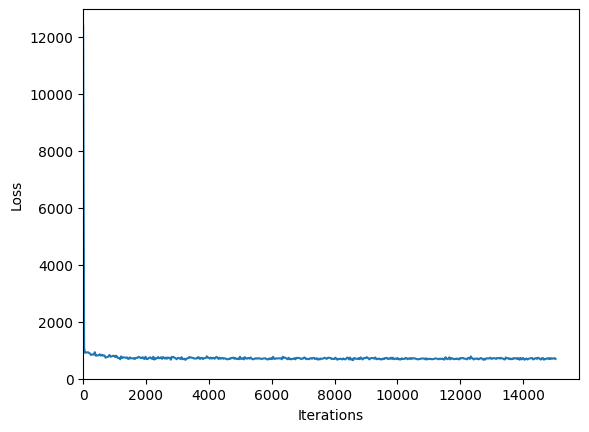

cuda


In [15]:
n_epochs = 80
batch_size = 64

runSGD(model, input_train_processed, target_train_processed, input_test_processed, target_test_processed, n_epochs=n_epochs, batch_size=batch_size)

In [16]:
input_test_processed = input_test_processed.to(device)
output = model(input_test_processed)  # Model output (logits or probabilities)
# torch.set_printoptions(profile="full")
# print(output)
output = output.cpu()
# Initialize a list to hold the decoded outputs for each observation
decoded_outputs = []

# incorrect_agent_num=0
# incorrect_agent_location=0
# incorrect_orientation=0
incorrect_cell=0
not_perfect=0

for i in range(output.size(0)):  # Loop over each sample in the batch
    # Extract the blocks of the output
    fist_NSQ = output[i]
    # second_block = output[i, input_train_processed.size(1)-7:input_train_processed.size(1)-4]    # Next block of size 3
    # third_block = output[i, input_train_processed.size(1)-7:]             # Last block of size 4

    # Decode each block by taking the argmax (index of max value)
    decoded_fist_NSQ = torch.round(fist_NSQ).long()  # 25 values, each between 0-10
    # decoded_second = torch.argmax(second_block)       # Single value between 0-2
    # decoded_third = torch.argmax(third_block)         # Single value between 0-3
    
    # map_array = map_numbers+[11,12,13]
    # in_map_array = torch.isin(decoded_fist_NSQ, torch.tensor(range(len(map_array))))
    # # Convert values not in map_array to len(map_array)
    # adjusted_values = torch.where(in_map_array, decoded_fist_NSQ, torch.tensor(len(map_array)))
    # mapping = torch.tensor(map_array+[-1])
    # decoded_fist_NSQ = mapping[adjusted_values]

    # num_agents = 0
    maybe_perfect=1

    # for j, val in enumerate(decoded_fist_NSQ):
    #     if (target_test[i, j] != val):
    #         maybe_perfect=0
    #         incorrect_cell +=1
        # if val >= 10 and num_agents == 0:
        #     decoded_second = val -10
        #     if (target_test[i, j] != 10):
        #         incorrect_agent_location+=1
        #         maybe_perfect=0
        # if val>= 10:
        #     num_agents +=1
        # if (target_test[i, j] != val and (val < 10 or target_test[i, j] < 10)):
        #     # print("cell", i)
        #     maybe_perfect=0
        #     incorrect_cell +=1
    
    # decoded_fist_NSQ[decoded_fist_NSQ > 10] = 10

    # if num_agents != 1:
    #     decoded_second = torch.tensor(-1, dtype=torch.long)
    #     maybe_perfect=0
    #     incorrect_agent_num +=1
    
    # if (decoded_second != target_orientation_test[i]):
    #     maybe_perfect=0
    #     incorrect_orientation +=1

    if not maybe_perfect:
        not_perfect +=1

    # Use torch.masked_select to get all matching values
    # matches = torch.masked_select(decoded_fist_NSQ, decoded_fist_NSQ >= 10)

    # Ensure it's a 1D tensor for concatenation
    # decoded_second = decoded_second.unsqueeze(0)

    # Combine the decoded values into a single list for this observation
    # decoded_sample = torch.cat([decoded_fist_NSQ, decoded_second])
    
    # Append the decoded sample to the final list
    decoded_outputs.append(decoded_fist_NSQ)

acc_cell = 1.0-(incorrect_cell/(WORLD_N_SQ*3*output.size(0)))
# acc_orientation = 1.0-(incorrect_orientation/output.size(0))
# acc_agentloc = 1.0-(incorrect_agent_location/output.size(0))
# acc_agentnum = 1.0-(incorrect_agent_num/output.size(0))
acc_perfect = 1.0-(not_perfect/output.size(0))

# Convert to tensor if needed
decoded_outputs = torch.stack(decoded_outputs)
print(decoded_outputs)

print ("Cell accuracy:", acc_cell)
# print ("Agent orientation accuracy:", acc_orientation)
# print ("Number of agents accuracy:", acc_agentnum)
# print ("Agent location accuracy:", acc_agentloc)
print ("Perfectness:", acc_perfect)

tensor([[118, 117, 117,  ..., 131, 132, 131],
        [117, 117, 117,  ..., 133, 133, 133],
        [129, 129, 129,  ..., 117, 117, 117],
        ...,
        [117, 117, 117,  ..., 131, 131, 131],
        [117, 118, 118,  ..., 131, 131, 131],
        [114, 115, 115,  ..., 134, 135, 135]])
Cell accuracy: 1.0
Perfectness: 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Action: 1
Target Orientation: 0 | Input Orientation: 76


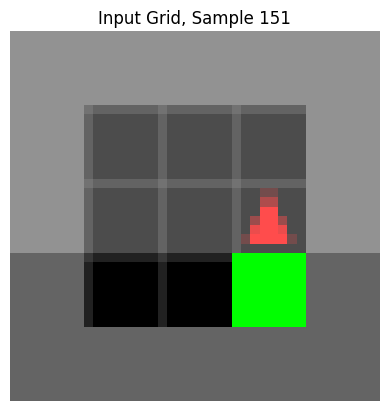

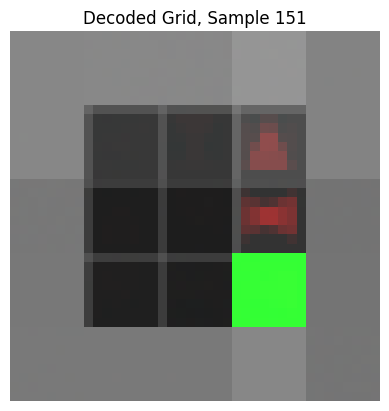

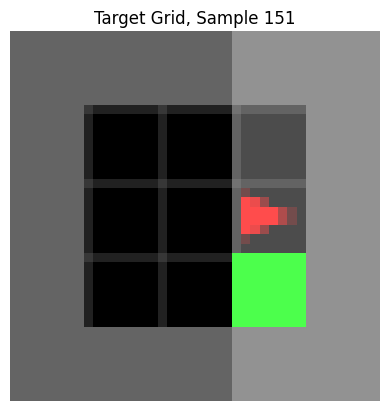

In [17]:
interval_min=150
interval_size=1
for i in range(interval_min,interval_min+min(interval_size,decoded_outputs.size(0))):
    # Print the input, decoded grid, and target test grid side by side
    # print(f"Sample {i + 1}:")
    
    # Input grid (first 25 values reshaped into 5x5)
    # print("Input Grid:")
    plt.figure()
    plt.axis('off')
    plt.title(f"Input Grid, Sample {i + 1}")
    plt.imshow(input_test[i, :-1].reshape(WORLD_N, WORLD_N, 3))
    # print(input_test[i, :-1].reshape(WORLD_N, WORLD_N).int())
    
    # Decoded grid (first 25 values reshaped into 5x5)
    # print("Decoded Grid:")
    plt.figure()
    plt.axis('off')
    plt.title(f"Decoded Grid, Sample {i + 1}")
    plt.imshow(decoded_outputs[i, :4800].reshape(WORLD_N, WORLD_N, 3))
    # print(decoded_outputs[i, :WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int())
    
    # Target test grid (first 25 values reshaped into 5x5)
    # print("Target Grid:")
    plt.figure()
    plt.axis('off')
    plt.title(f"Target Grid, Sample {i + 1}")
    plt.imshow(target_test[i, :-1].reshape(WORLD_N, WORLD_N, 3))
    # print(target_test[i, :WORLD_N_SQ*3].reshape(WORLD_N, WORLD_N).int())
    
    # Action and Orientation for input, decoded, and target test
    print(f"Input Action: {input_test[i, 3*WORLD_N_SQ].item()}")
    print(f"Target Orientation: {target_orientation_test[i].item()} | Input Orientation: {input_orientation_test[i].item()}")
    
    print("=" * 50)  # Separator


0